# Data Structures


In [1]:
import uxarray as ux
import xarray as xr

C:\Users\chmie\anaconda3\envs\uxarray_build\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


The core functionality of UXarray revolves around three data structures, which are used for interacting with unstructured grids and the data variables that reside on them.

1. **[`uxarray.Grid`](https://uxarray.readthedocs.io/en/latest/user_api/generated/uxarray.UxDataArray.html)**: Stores the grid representation (i.e. coordinates, connectivity information, etc.)
2. **[`uxarray.UxDataset`](https://uxarray.readthedocs.io/en/latest/user_api/generated/uxarray.UxDataset.html)**: One or more data variable that resided on a grid.
3. **[`uxarray.UxDataArray`](https://uxarray.readthedocs.io/en/latest/user_api/generated/uxarray.UxDataArray.html)**: A single data variable that resides on a grid 


## Grid and Data Files


When working with unstructured grid datasets, the grid definition is typically stored separately from any data variables. 

For example, the dataset used in this example is made up of two files: a single grid definition and a single data file.


```
quad-hexagon
│   grid.nc
│   data.nc
```

In [2]:
grid_path = "../../test/meshfiles/ugrid/quad-hexagon/grid.nc"
data_path = "../../test/meshfiles/ugrid/quad-hexagon/data.nc"

Additionally, there may be multiple data files that are mapped to the same unstructured grid (such as the case with climate model output). Using our sample dataset, this may look something like this:

```
quad-hexagon
│   grid.nc
│   data1.nc
|   data2.nc
|   data3.nc
```

We can store these paths as a list (in this case we simply repeat the original data file to imitate having 4 separate data files)

In [3]:
multiple_data_paths = [data_path for i in range(3)]

## Grid

The `Grid` class is used for storing variables associated with an unstructured grid's topology. This includes dimensions, coordinates, and connectivity variables.

### Creating a Grid

The recommended way to construct a `Grid` is by using the `ux.open_grid()` method, which takes in a grid file path, detects the input grid format, and parses and encodes the provided coordinates and connectivity into the UGRID conventions. Details on supported grid formats and what variables are parsed can be found in other parts of this user guide.

In [4]:
uxgrid = ux.open_grid(grid_path)
uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 16
  * n_edge: 19
  * n_face: 4
  * n_max_face_nodes: 6
  * two: 2
  * n_nodes_per_face: (4,)
Grid Coordinates (Spherical):
  * node_lon: (16,)
  * node_lat: (16,)
  * edge_lon: (19,)
  * edge_lat: (19,)
  * face_lon: (4,)
  * face_lat: (4,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (4, 6)
  * edge_node_connectivity: (19, 2)
Grid Descriptor Variables:

### Accessing Variables

As we saw above when printing out Grid instance, there are many variables that are associated with a single grid. In addition to the general repr, we can obtain the stored dimensions, coordinates, and connectivity variables through the following attributes.



In [5]:
uxgrid.dims

{'n_edge', 'n_face', 'n_max_face_nodes', 'n_node', 'two'}

In [6]:
uxgrid.sizes

{'n_edge': 19, 'n_face': 4, 'n_max_face_nodes': 6, 'two': 2, 'n_node': 16}

In [7]:
uxgrid.coordinates

{'edge_lat', 'edge_lon', 'face_lat', 'face_lon', 'node_lat', 'node_lon'}

In [8]:
uxgrid.connectivity

{'edge_node_connectivity', 'face_node_connectivity'}

We can access any desired quantity by either calling an attribute by the same name or by indexing a Grid like a dictionary.

In [9]:
uxgrid.node_lon

<xarray.DataArray 'node_lon' (n_node: 16)>
array([-0.038411, -0.186448, -0.181994, -0.047552,  0.100399,  0.096181,
        0.105031,  0.239774, -0.177116, -0.325237,  0.378854,  0.382835,
       -0.042753, -0.320659,  0.235225,  0.243879], dtype=float32)
Dimensions without coordinates: n_node
Attributes:
    standard_name:  longitude
    long_name:      longitude of mesh nodes
    units:          degrees_east

In [10]:
uxgrid["node_lon"]

<xarray.DataArray 'node_lon' (n_node: 16)>
array([-0.038411, -0.186448, -0.181994, -0.047552,  0.100399,  0.096181,
        0.105031,  0.239774, -0.177116, -0.325237,  0.378854,  0.382835,
       -0.042753, -0.320659,  0.235225,  0.243879], dtype=float32)
Dimensions without coordinates: n_node
Attributes:
    standard_name:  longitude
    long_name:      longitude of mesh nodes
    units:          degrees_east

### Constructing Additional Variables

Looking at `Grid.connectivity` one more time, we can see that there are only two available variables. 

In [11]:
uxgrid.connectivity

{'edge_node_connectivity', 'face_node_connectivity'}

These variables were the ones that were able to be parsed and encoded in the UGRID conventions from the inputted grid file. 

In addition to parsing variables, we can construct additional variables by calling the attribute or indexing the Grid with the desired name. For example, if we wanted to construct the `face_edge_connectivity`, we would do the following:

In [12]:
uxgrid.face_edge_connectivity

<xarray.DataArray 'face_edge_connectivity' (n_face: 4, n_max_face_edges: 6)>
array([[ 0,  3,  5,  6,  7,  1],
       [12, 10, 11,  2,  1,  9],
       [ 2, 14, 13, 15,  4,  0],
       [ 8, 18, 16, 17,  9,  7]], dtype=int64)
Dimensions without coordinates: n_face, n_max_face_edges
Attributes:
    cf_role:      face_edge_connectivity
    long name:    Maps every face to its edges.
    start_index:  0
    _FillValue:   -9223372036854775808
    dtype:        <class 'numpy.int64'>

Now if we look at our `Grid.connectivity`, we can see that it now contains our new connectivity variable.

In [13]:
uxgrid.connectivity

{'edge_node_connectivity', 'face_edge_connectivity', 'face_node_connectivity'}

All grid variables are internally stored as a Python property. At the time the user calls the attribute (in the above example `uxgrid.face_edge_connectivity`), there is code in place to check whether the variable is present within the `Grid`. If it's available, it is directly returned to the user, otherwise it is constructed.


## UxDataset

Up to this point, we've exclusively looked at the unstructured grid without any data variables mapped to it. Working with a standalone `Grid` has its applications, such as grid debugging and analysis, however more commonly an unstructured grid is paired with data variables that are mapped to it.  

The `UxDataset` class is used for pairing one or more data variables with an unstructured grid. It operates similarly to a `xarrary.Dataset`, with the addition of unstructured-grid specific functionality and is linked to an instance of a `Grid`.

```{info}
More information about `xarray.Dataset` can be found [here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).
```


### Opening a Single Data File

We can load a pair of grid and data files using the `ux.open_dataset()` method.


In [14]:
uxds = ux.open_dataset(grid_path, data_path)
uxds

<xarray.UxDataset>
Dimensions:  (n_face: 4)
Dimensions without coordinates: n_face
Data variables:
    t2m      (n_face) float32 297.6 297.6 297.7 297.3

### Opening Multiple Data Files

When working with multiple data paths, we can open them using the `ux.open_mfdataset()` method. 

In [15]:
uxds_multi = ux.open_mfdataset(
    grid_path, multiple_data_paths, combine="nested", concat_dim="time"
)
uxds_multi

<xarray.UxDataset>
Dimensions:  (time: 3, n_face: 4)
Dimensions without coordinates: time, n_face
Data variables:
    t2m      (time, n_face) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>

## Grid Accessor

Each `UxDataset` (and in the next section `UxDataArray`) is linked to a `Grid` instance, which contain the unstructured grid information.

In [16]:
uxds.uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 16
  * n_edge: 19
  * n_face: 4
  * n_max_face_nodes: 6
  * two: 2
  * n_nodes_per_face: (4,)
Grid Coordinates (Spherical):
  * node_lon: (16,)
  * node_lat: (16,)
  * edge_lon: (19,)
  * edge_lat: (19,)
  * face_lon: (4,)
  * face_lat: (4,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (4, 6)
  * edge_node_connectivity: (19, 2)
Grid Descriptor Variables:

All the same functionality can be performed using the `uxgrid` attribute as was discussed in the `Grid` sections above.

In [17]:
uxds.uxgrid.dims

{'n_edge', 'n_face', 'n_max_face_nodes', 'n_node', 'two'}

## UxDataArray



While a `UxDataset` represents one or more data variables linked to some unstructured grid, a `UxDataArray` represent a single data variable. Alternatively, one can think of a `UxDataset` as a collection of one or more `UxDataArray` instances.

```{info}
More information about `xarray.DataArray` can be found [here](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html).
```

In our sample dataset, we have a variable called `t2m`, which can be used to index our `UxDataset`


In [18]:
uxds["t2m"]

<xarray.UxDataArray 't2m' (n_face: 4)>
array([297.58316, 297.64578, 297.71643, 297.25037], dtype=float32)
Dimensions without coordinates: n_face
Attributes:
    units:      K
    long_name:  2-meter temperature

We can see the relationship between a `UxDataset` and `UxDataArray` by checking the type.

In [19]:
type(uxds), type(uxds["t2m"])

(uxarray.core.dataset.UxDataset, uxarray.core.dataarray.UxDataArray)

As mentioned before, each `UxDataArray` is linked to a `Grid` instance.

In [20]:
uxds["t2m"].uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 16
  * n_edge: 19
  * n_face: 4
  * n_max_face_nodes: 6
  * two: 2
  * n_nodes_per_face: (4,)
Grid Coordinates (Spherical):
  * node_lon: (16,)
  * node_lat: (16,)
  * edge_lon: (19,)
  * edge_lat: (19,)
  * face_lon: (4,)
  * face_lat: (4,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (4, 6)
  * edge_node_connectivity: (19, 2)
Grid Descriptor Variables:

This Grid is identical to the one linked to the `UxDataset`. Regardless of the number of data variables present in the `UxDataset`, they all share a single `Grid` instance. 

In [21]:
uxds["t2m"].uxgrid == uxds.uxgrid

True

### Functionality

Just like with Xarray, we can perform various operations on our data variable.


In [22]:
uxds["t2m"].min()

<xarray.UxDataArray 't2m' ()>
array(297.25037, dtype=float32)

In [23]:
uxds["t2m"].mean()

<xarray.UxDataArray 't2m' ()>
array(297.54895, dtype=float32)

UXarray also provides custom data analysis operators which are explored in further sections of this user guide.

In [24]:
uxds["t2m"].gradient()

<xarray.UxDataArray 't2m_grad' (n_edge: 19)>
array([28.00277097, 20.66935101, 29.23128307,  0.        ,  0.        ,
        0.        ,  0.        , 60.59822029,  0.        , 86.32623052,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])
Dimensions without coordinates: n_edge

## Inheritance from Xarray

For those that are familiar with Xarray, the naming of the methods and data structures looks familiar. UXarray aims to provide a familiar experience to Xarray by inheriting the `xr.Dataset` and `xr.DataArray` objects and linking them to an instance of a `Grid` class to provide grid-aware implementations.

We can observe this inheritance by checking for subclassing.

In [25]:
issubclass(ux.UxDataset, xr.Dataset)

True

In [26]:
issubclass(ux.UxDataArray, xr.DataArray)

True

## Overloaded Methods

With subclassing, all methods are directly inherited from the parent class (`xr.Dataset`). Most Xarray functionality works directly on UXarray's data structures, however certain methods have been overloaded to make them unstructured-grid aware.

One example of this is the plotting functionality of a `ux.UxDataArray`, which was re-implemented to support visualuzations of unstructured grids. A detailed overview of plotting functionality can be found in the next sections.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Image   [x,y]   (x_y t2m)
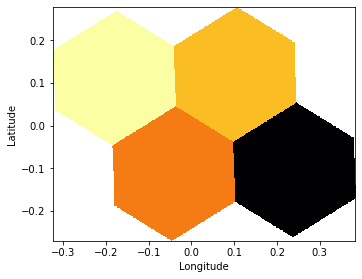

In [27]:
uxds["t2m"].plot(fig_size=150, colorbar=False, cmap="inferno", backend="matplotlib")